In [5]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram
import spopt
from spopt.region import MaxPHeuristic as MaxP
import libpysal
import warnings
import pysal as ps
import plotly.express as px

## 1. Read data

In [25]:
#read in os and pt data
df = pd.read_csv('data/clean/df_data_standardised.csv')

df.head()

,NAME,geometry,gcse_2013,ptal_2013,nature_access_2013,median_house_2014_log,pollution_2008,burglariesper1000residents
0,Chessington South,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",0.274809,0.164179,0.935961,0.199280,0.098507,0.107427
1,Tolworth and Hook Rise,"POLYGON ((517829.6 165447.1, 517837.1 165469.4...",0.282443,0.149254,0.285714,0.221922,0.226866,0.192158
2,Berrylands,"POLYGON ((518107.5 167303.4, 518114.3 167307.5...",0.343511,0.223881,0.475369,0.244721,0.188060,0.228683
3,Alexandra,"POLYGON ((520480 166909.8, 520490.7 166901.9, ...",0.465649,0.134328,0.406404,0.282830,0.200000,0.124839
4,Beverley,"POLYGON ((522071 168144.9, 522063.9 168144, 52...",0.564885,0.223881,0.593596,0.306613,0.176119,0.241471


## 2. Number of clusters

In [26]:
# variables to cluster
vars_cluster = ['gcse_2013', 'ptal_2013', 'nature_access_2013', 'median_house_2014_log', 
                'pollution_2008', 'burglariesper1000residents']

#### a. Elbow plot with SSE

In [27]:
#create an empty list
list_SSE = []
#set ther ange of clusters to evaluate
min_k = 1
max_k = 15
range_k = range(min_k, max_k)

#iterate over the range
for i in range_k:
    #perform the clustering algorithm
    km = KMeans(n_clusters = i,
               init = "random",
               n_init = 10,            # 10 different initialisation
               max_iter = 300,         # Max iteration for each initialised clustering
               tol = 1e-04,            
               random_state = 42)
    #fit this to the data
    km.fit(df[vars_cluster])
    #add the SEE score
    list_SSE.append(km.inertia_)   


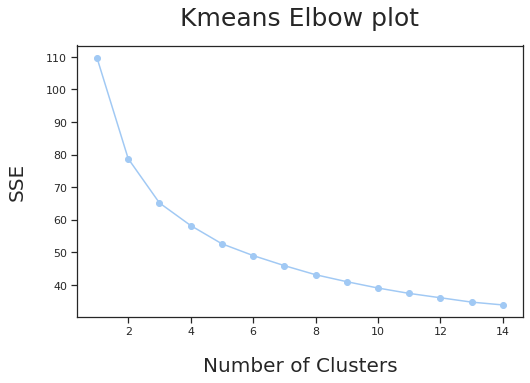

In [28]:
#create the base plots
fig, ax = plt.subplots(1,1, figsize = (8,5))

#add the data to the axis
ax.plot(range_k, list_SSE, marker = "o")

#add the necessary labels
ax.set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("SSE", fontsize =20, labelpad = 20)
ax.set_title("Kmeans Elbow plot", fontsize = 25, pad = 20)

plt.show()
os.makedirs('data/plot', exist_ok=True)
fig.savefig(os.path.join('data','plot','elbow.jpg'))

#### b. Silhouette plot

In [29]:
#create an empty list
silhouette = []

for i in range(2,15):
    #should ideally take the average of ~10 iterations, but due to the capacity, only conduct once
       
    #set the number of clusters
    print(i)
    k_cluster = i 
    #apply the KMeans clustering algorithm
    kmeans_method = KMeans(n_clusters = k_cluster)
    kmeans_method.fit(df[vars_cluster])

    #extract the labels
    labels = kmeans_method.labels_
    #extract the silhouette score
    a = metrics.silhouette_score(df[vars_cluster], labels)

    #append
    silhouette.append(a)

2
3
4
5
6
7
8
9
10
11
12
13
14


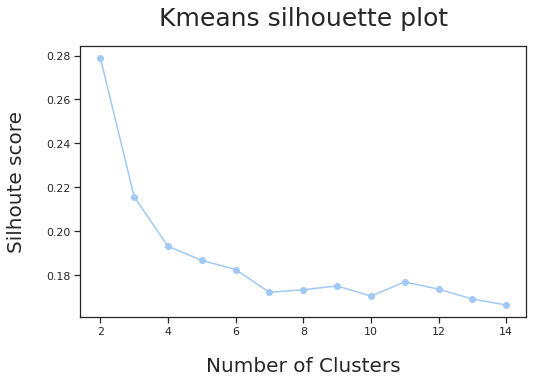

In [30]:
#create a base axis
fig, ax = plt.subplots(1,1, figsize = (8,5))

#plot the results
ax.plot(range(2,15), silhouette, marker = "o")

#add the lbels
ax.set_xlabel("Number of Clusters", fontsize = 20, labelpad = 20)
#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Silhoute score", fontsize =20, labelpad = 20)
ax.set_title("Kmeans silhouette plot", fontsize = 25, pad = 20)

plt.show()
os.makedirs('output', exist_ok=True)
fig.savefig(os.path.join('output','silhouette.jpg'))

## 3. Clustering

In [31]:
#perform the clustering with the chosen number of clusters of 2
kmeans_method = KMeans(n_clusters = 6,
                       random_state = 42,
                       n_init = 10)         # Take average of 10 iterations
kmeans_method.fit(df[vars_cluster])

KMeans(n_clusters=6, random_state=42)

In [32]:
#extract the cluster labels and add these back to the master data
labels = kmeans_method.labels_
df["labels"] = labels + 1 #adjusting the indexing to start at 1

## 4. Component analysis# variables to cluster
vars_cluster = ['gcse_2013', 'ptal_2013', 'nature_access_2013', 'median_house_2014_log', 
                'pollution_2008', 'burglariesper1000residents']

In [33]:
# variables to cluster
vars_cluster = ['gcse_2013', 'ptal_2013', 'nature_access_2013', 'median_house_2014_log', 
                'pollution_2008', 'burglariesper1000residents']

<Figure size 432x288 with 0 Axes>

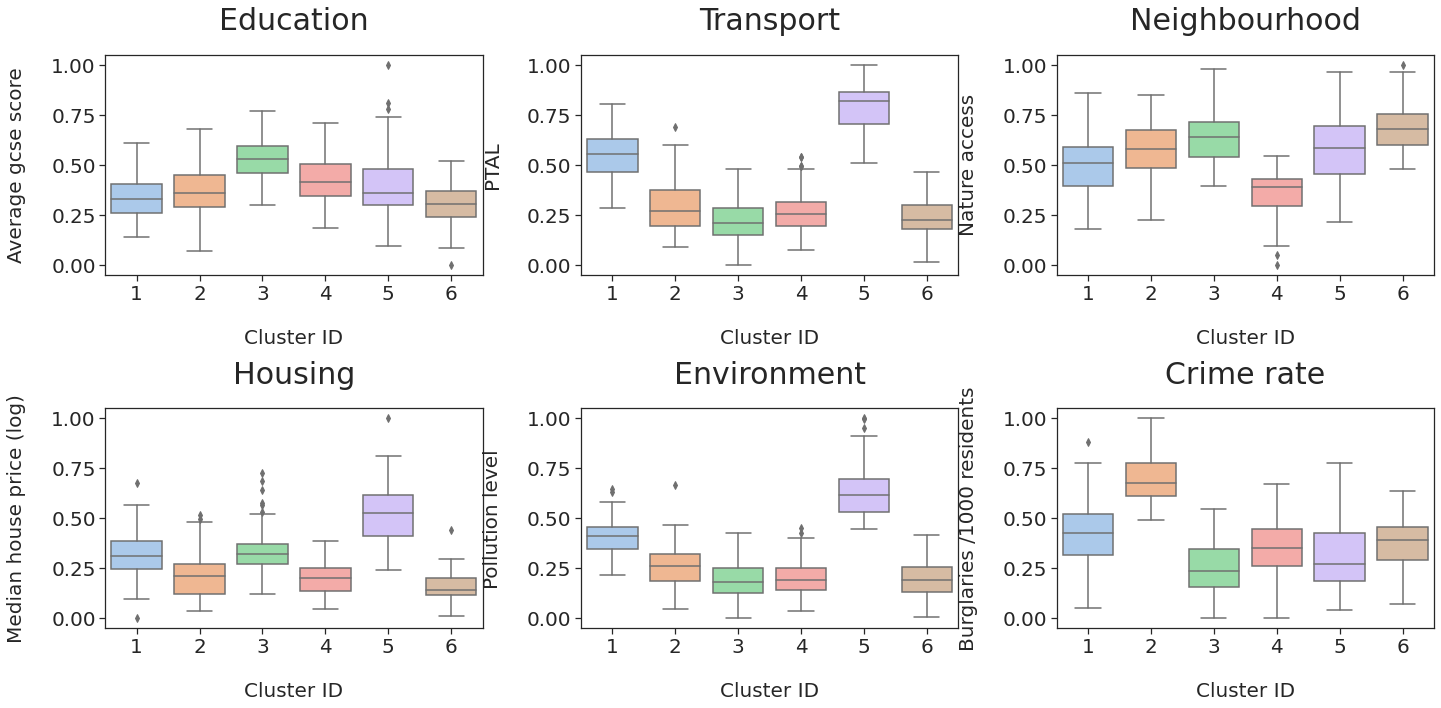

In [34]:
#creating boxplots to umderstand the cluster characteristics

#set the titles and labels
titles = ['Education', 'Transport', 'Neighbourhood', 'Housing','Environment', 'Crime rate']
ylabels = ["Average gcse score", "PTAL", "Nature access", "Median house price (log)",
           "Pollution level", "Burglaries /1000 residents"]

#create a base plot with seaborn
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
sns.despine(offset = 10) 
fig, ax = plt.subplots(2,3, figsize = (20,10))
axis = ax.flatten()

#iterate over each column to create (6 variables x 4 clusters) of boxplots
for i, col in enumerate(vars_cluster):

    sns.boxplot(y=df[col], x=df['labels'], ax=axis[i])   # Plotting   
    #set the plots up
    axis[i].set_title(titles[i], fontsize = 30, pad = 25)
    axis[i].set_xlabel("Cluster ID", fontsize = 20, labelpad = 25)
    #axis[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axis[i].set_ylabel(ylabels[i], fontsize =20, labelpad = 25)
    axis[i].tick_params(axis = "both", labelsize = 20)

#set the layout to tight so no overalp
plt.tight_layout()

# Save
os.makedirs('output', exist_ok=True)
fig.savefig(os.path.join('output','component_box.jpg'))

AttributeError: 'Line2D' object has no property 'column'

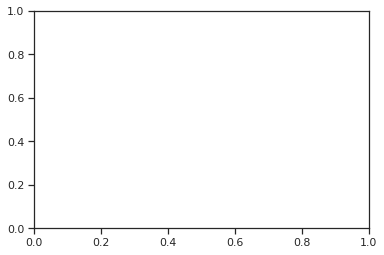